INSTALL PACKAGES

In [2]:
# # You only need to run this once per machine
# %pip install -q -U bitsandbytes
# %pip install -q -U git+https://github.com/huggingface/transformers.git
# %pip install -q -U git+https://github.com/huggingface/peft.git
# %pip install -q -U git+https://github.com/huggingface/accelerate.git
# %pip install -q -U datasets scipy ipywidgets matplotlib einops


**Accelerator**

In [1]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

c:\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Weights & Biases**

In [4]:
# %pip install -q wandb -U

# import wandb, os
# wandb.login()

# wandb_project = "journal-finetune"
# if len(wandb_project) > 0:
#     os.environ["WANDB_PROJECT"] = wandb_project

**Load Dataset**

In [2]:
from datasets import load_dataset

train_dataset = load_dataset('json', data_files='train_conversation_data.jsonl', split='train')
eval_dataset = load_dataset('json', data_files='test_conversation_data.jsonl', split='train')

In [5]:
print(train_dataset)

Dataset({
    features: ['id', 'conversation_pairs'],
    num_rows: 176
})


**Formatting prompts**

In [7]:
# def formatting_func(example):
#     text = f"### The following is a conversation pair list between patient and doctor: {example['conversation_pairs']}"
#     return text

def formatting_func(example):
    conversation_pairs = example.get("conversation_pairs", [])
    prompt = ""
    for pair in conversation_pairs:
        if "patient" in pair and "doctor" in pair:
            prompt += f"### Patient: {pair['patient']}\n ### Doctor: {pair['doctor']}\n"
    return prompt.strip()  # Remove trailing newline if present

**Load Base Model**

In [8]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

base_model_id = "microsoft/phi-2"
model = AutoModelForCausalLM.from_pretrained(base_model_id, trust_remote_code=True, torch_dtype=torch.float16, load_in_8bit=True)

Loading checkpoint shards: 100%|██████████| 2/2 [00:04<00:00,  2.39s/it]


In [9]:
from torch.utils.cpp_extension import CUDA_HOME
print(CUDA_HOME) # by default it is set to /usr/local/cuda/

C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v12.4


**Tokenization**

In [10]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
    use_fast=False, # needed for now, should be fixed soon
)
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [11]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

Map: 100%|██████████| 37/37 [00:00<00:00, 118.59 examples/s]


In [12]:
%pip install matplotlib


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


213


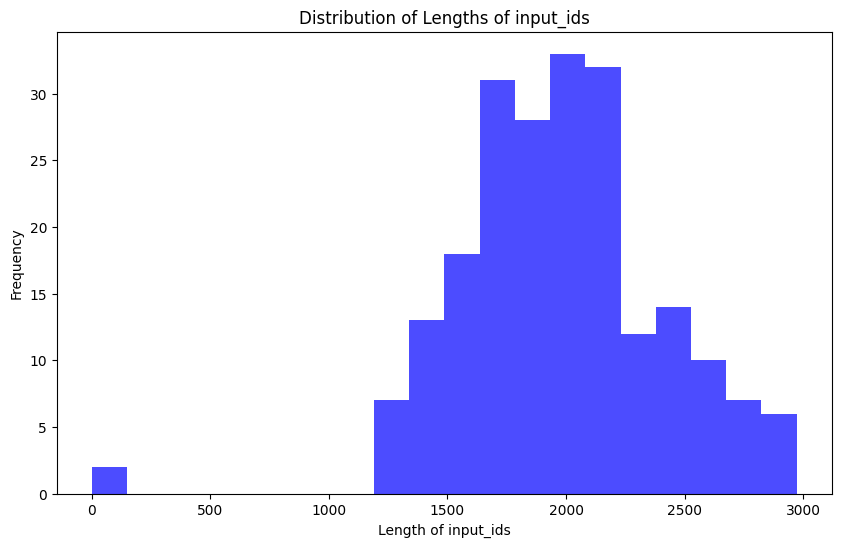

In [13]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [14]:
max_length = 512 # This was an appropriate max length for my dataset

def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [15]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt2)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt2)

Map: 100%|██████████| 37/37 [00:00<00:00, 121.69 examples/s]


In [16]:
print(tokenized_train_dataset[1]['input_ids'])

[50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256

213


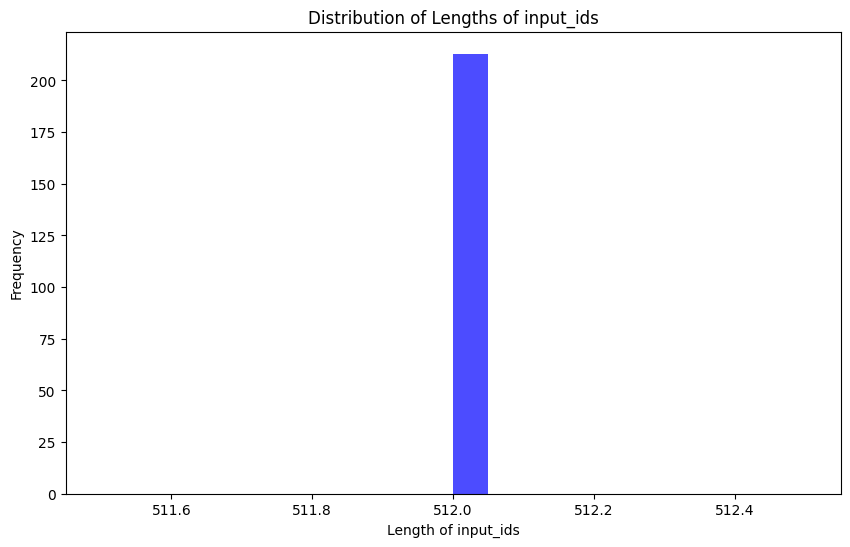

In [17]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

**Set Up LoRA**

In [18]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [19]:
print(model)

PhiForCausalLM(
  (model): PhiModel(
    (embed_tokens): Embedding(51200, 2560)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x PhiDecoderLayer(
        (self_attn): PhiAttention(
          (q_proj): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
          (k_proj): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
          (v_proj): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
          (dense): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
          (rotary_emb): PhiRotaryEmbedding()
        )
        (mlp): PhiMLP(
          (activation_fn): NewGELUActivation()
          (fc1): Linear8bitLt(in_features=2560, out_features=10240, bias=True)
          (fc2): Linear8bitLt(in_features=10240, out_features=2560, bias=True)
        )
        (input_layernorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (

 LoRA config

In [20]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "Wqkv",
        "fc1",
        "fc2",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 26214400 || all params: 2805898240 || trainable%: 0.9342605382581515


In [21]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): PhiForCausalLM(
      (model): PhiModel(
        (embed_tokens): Embedding(51200, 2560)
        (embed_dropout): Dropout(p=0.0, inplace=False)
        (layers): ModuleList(
          (0-31): 32 x PhiDecoderLayer(
            (self_attn): PhiAttention(
              (q_proj): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
              (k_proj): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
              (v_proj): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
              (dense): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
              (rotary_emb): PhiRotaryEmbedding()
            )
            (mlp): PhiMLP(
              (activation_fn): NewGELUActivation()
              (fc1): lora.Linear8bitLt(
                (base_layer): Linear8bitLt(in_features=2560, out_features=10240, bias=True)
                (lora_dropout): ModuleDict(
                  (default): D

**Run Training**

In [22]:
model = accelerator.prepare_model(model)

In [23]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [24]:
import transformers
from datetime import datetime

project = "journal-finetune"
base_model_name = "phi2"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=1,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        max_steps=500,
        learning_rate=2.5e-5, # Want a small lr for finetuning
        optim="paged_adamw_8bit",
        logging_steps=25,              # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=25,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=25,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        # report_to="wandb",           # Comment this out if you don't want to use weights & baises
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

  3%|▎         | 13/500 [05:12<3:14:22, 23.95s/it]

**Drum Roll... Try the Trained Model!**

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

base_model_id = "microsoft/phi-2"
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Phi2, same as before
    device_map="auto",
    trust_remote_code=True,
    load_in_8bit=True,
    torch_dtype=torch.float16,
)

eval_tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True, use_fast=False)
eval_tokenizer.pad_token = tokenizer.eos_token

In [ ]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, "phi2-journal-finetune/checkpoint-500")

In [ ]:
eval_prompt = " The following is a note by Eevee the Dog: # Today I "
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=100, repetition_penalty=1.11)[0], skip_special_tokens=True))